# Validazione e Regolarizzazione

Vi ricordate che nel laboratorio precedente avevamo lasciato in sospeso il come scegliere k, ossia il parametro di KNN?
Oggi andremo a studiare come implementare un meccanismo di validazione dei parametri, noto come Cross Validation.

<a target="_blank" href="https://colab.research.google.com/github/zangobot/BusinessAnalytics_TeachingMaterial/blob/main/Validazione%20e%20Regolarizzazione.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [9]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, encoder, **params):
    Z = encoder.transform(clf.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_region(clf, X, Y, title, x_label, y_label, classes, color='rgb'):
    colors = cycle(color)
    encoder = LabelEncoder().fit(Y)
    X0, X1 = X[x_label], X[y_label]
    xx, yy = make_meshgrid(X0, X1)
    fig, ax = plt.subplots()
    plot_contours(ax, clf, xx, yy, encoder, cmap=plt.cm.coolwarm, alpha=0.8)
    for c in classes:
        X[Y == c].plot.scatter(x_label, y_label, ax=ax, color=next(colors), label=c)
    ax.set_title(title)



data = pd.read_csv('dati/penguins_size.csv').dropna()
X = data[['culmen_length_mm', 'culmen_depth_mm']]
Y = data['species']

knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X,Y)

knn5  = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X,Y)

knn10  = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X,Y)

KNeighborsClassifier(n_neighbors=10)

/Users/zangobot/opt/miniconda3/envs/tai/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/zangobot/opt/miniconda3/envs/tai/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/zangobot/opt/miniconda3/envs/tai/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


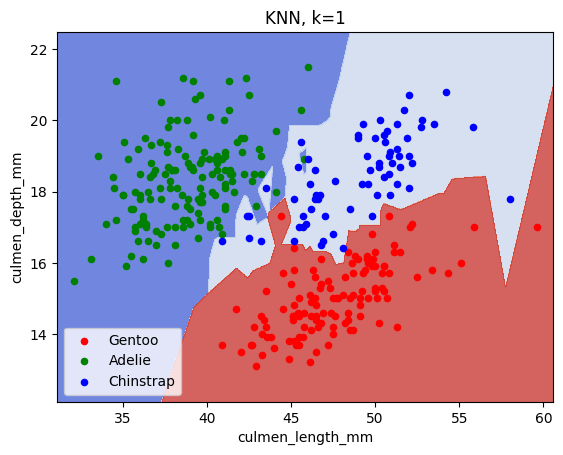

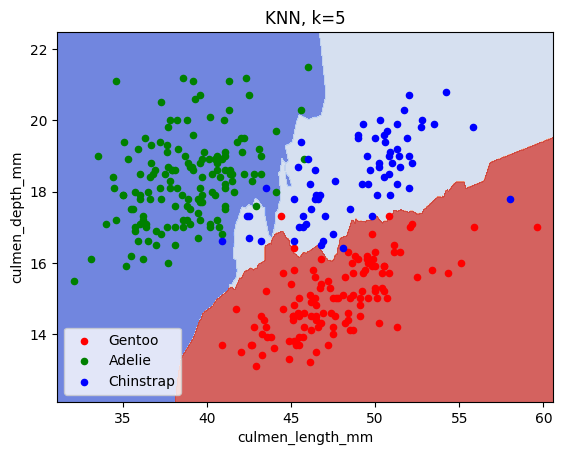

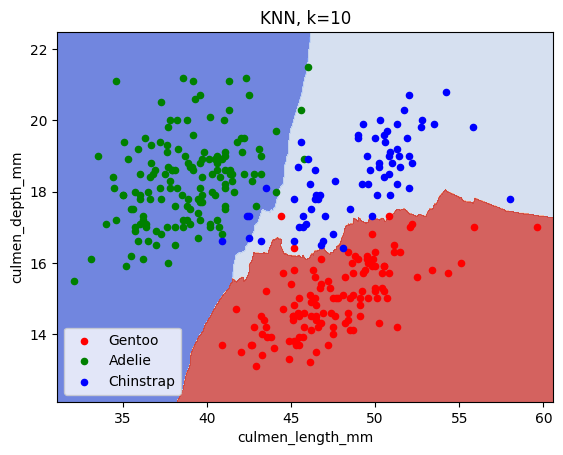

In [10]:
plot_decision_region(knn1, X, Y, f"KNN, k={1}", "culmen_length_mm", "culmen_depth_mm", classes=["Gentoo", "Adelie", "Chinstrap"])
plot_decision_region(knn5, X, Y, f"KNN, k={5}", "culmen_length_mm", "culmen_depth_mm", classes=["Gentoo", "Adelie", "Chinstrap"])
plot_decision_region(knn10, X, Y, f"KNN, k={10}", "culmen_length_mm", "culmen_depth_mm", classes=["Gentoo", "Adelie", "Chinstrap"])

Come potete osservare, al variare di k la funzione imparata diventa sempre più complicata e meno liscia.
Secondo voi, quale modello si comporterà meglio su dati che verrano resi disponibili nel futuro?
Come facciamo a gestire dati che ancora non abbiamo disponibili?

## Bias Variance trade off

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Bias_and_variance_contributing_to_total_error.svg/2880px-Bias_and_variance_contributing_to_total_error.svg.png" width=1000>

All'aumentare della complessità del modello e della varianza dei dati, il classificatore perde potere predittivo.
Quindi, non tutti i modelli (esempio: la scelta di k) vanno bene, bisogna analizzare le performance al variare dei parametri del modello per trovare
quello che minimizza l'errore sui dati futuri.

Per mimare questo comportamento, dobbiamo dividere i dati di training in due parti: *training* e *test*.

## Training
Sono i dati che usiamo per allenare, quelli che abbiamo raccolto e che servono per capire se il modello scelto possa andare bene o meno.
Un modello è buono sui dati di training quando l'errore di classificazione è basso.

## Test
Separato dal training, questo insieme di dati viene usato per calcolare l'accuratezza **dopo** aver allenato il modello.
Se il modello ottiene una buona accuratezza anche su dati che non ha mai visto, allora significa che il modello sta generalizzando bene su dati mai visti, quindi l'accuratezza è affidabile.
Una volta che si sono trovati i parametri giusti, allora si può ri-allenare il modello con tutti i dati.

# Cross Validation

Introduciamo finalmente l'algoritmo per trovare i parametri del modello, ossia la Cross Validation.
* divido i dati in training e test
* alleno il classificatore sui dati di training
* calcolo, per ogni combinazione dei parametri l'accuratezza sul train e sul test
* scelgo i parametri in base al modello che minimizza entrambi

La libreria sklearn offre metodi per effettuare questo split, quindi possiamo implementare il nostro algoritmo di cross-validazione.

K = 1, Train Accuracy: 1.00 Test Accuracy 0.94
K = 3, Train Accuracy: 0.97 Test Accuracy 0.99
K = 5, Train Accuracy: 0.96 Test Accuracy 0.97
K = 10, Train Accuracy: 0.97 Test Accuracy 0.96
K = 20, Train Accuracy: 0.96 Test Accuracy 0.96
K = 30, Train Accuracy: 0.95 Test Accuracy 0.96
K = 50, Train Accuracy: 0.91 Test Accuracy 0.94


[]

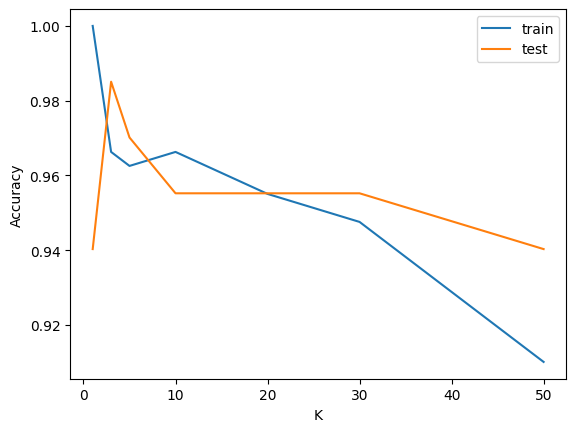

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

ks = [1, 3, 5, 10, 20, 30, 50]
all_test_accuracy = []
all_train_accuracy = []
for k in ks:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train, y_train)
    y_pred_train = knn_k.predict(X_train)
    y_pred_test = knn_k.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f'K = {k}, Train Accuracy: {train_accuracy:.2f} Test Accuracy {test_accuracy:.2f}')
    all_train_accuracy.append(train_accuracy)
    all_test_accuracy.append(test_accuracy)

plt.plot(ks, all_train_accuracy, label='train')
plt.plot(ks, all_test_accuracy, label='test')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.plot()

Come vedete, sembrerebbe che k=3 sia il valore ottimale, ossia quello che generalizza meglio sui dati futuri.
... oppure anche questo dato è sbagliato?
Secondo voi che cosa manca per avere una valutazione veramente ottimale?

Consiglio: come decido i dati di test? Vanno bene quei dati di test?

Non sarebbe meglio avere più "test"?

**Soluzione**: dati di *validation*.
Aggiungiamo una terza divisione dei dati, durante il training.
Ma non lo faccio una volta: ripeto questa divisione più volte, andando a pescare sempre dati di validation diversi.
In questo modo, mimo il comportamento dei dati di training e medio i risultati, rendendo la misura di accuratezza più consistente dal punto di vista statistico.

<img src="https://imgs.search.brave.com/KGuXbcNLUsXxOpnEQJeT3WKip-e0SyshNGgKdPhFwho/rs:fit:708:393:1/g:ce/aHR0cHM6Ly9kYW5y/b2RnYXIuZ2l0aHVi/LmlvL0RBU0UvZmln/dXJlcy9rZm9sZC5w/bmc">

Possiamo implementare questo meccanismo a mano, oppure possiamo usare una funzione di libreria di scikit-learn.

In [23]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors' : ks}, cv=10)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

print(grid_search.best_estimator_)

print(f'Test accuracy: {accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))}')

{'n_neighbors': 3}
KNeighborsClassifier(n_neighbors=3)
Test accuracy: 0.9850746268656716


Ora siamo sicuri che 3 sia un buon parametro per il nostro modello sui nostri dati.
Possiamo quindi allenare KNN su tutti i dati con k=3.

In [24]:
final_knn = KNeighborsClassifier(n_neighbors=3)
final_knn.fit(X,Y)

print(f'Accuracy: {accuracy_score(Y, final_knn.predict(X))}')

Accuracy: 0.9760479041916168
